# Specific Task (DeepLense): Exploring Transformers
### Chenguang Guan

## Workflow of ViT

In the original Transformer for NLP, there are both attention-based encoders and decoders.

However, there is only attention-based encoder in ViT. The ViT introduces patch embedding to transform 2D image-patches to flatten embedding vectors ("Images to Words"), while they also develop some other positional embedding including 2-D/relative/learnable embedding beyond the 1-D positional embedding in NLP Transformer. Finally, they borrows the idea of class token from $\textbf{BERT}$ to classify the images.

1. Patch Embedding: $\mathbf{x} \in \mathbb{R}^{H \times W \times C}\rightarrow\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$

2. Class Token: Borrow from the BERT model.

3. Position Embeidding: learnable 1D postion embeddings, 2D postion embeddings, etc.

4. Incorporating position information in the model: Add before feeding into the transformer encoder; Add before each encoder block; Add before each encoder block (shared weights).

5. Transformer Encoder Block: same as NLP transformer.
MLP for the class token

## Workflow of Swin Transformer

The differences between original ViT and Swin Transformer are their attetion mechanism. The attention mechanism of Swin Transformer is hierarchical attention.

With the coarse graining going on, the size of each patch is getting larger (similar with Renormalization Group in Physics).

$\left(H_{\text{Patch}}, W_{\text{Patch}}\right)\rightarrow \left(2H_{\text{Patch}}, 2W_{\text{Patch}}\right)\rightarrow \left(4H_{\text{Patch}}, 4W_{\text{Patch}}\right)\rightarrow ...$

## I. Preparation

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!tar -xzvf /content/gdrive/MyDrive/lenses.tgz 

In [3]:
import numpy as np
import glob
import os

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms

import random
import time


from sklearn import metrics

import matplotlib.pyplot as plt

from PIL import Image

In [4]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


## II. Dataset

In [5]:
dataset_path = '/content/lenses'

In [45]:
def dataset_path_list(dataset_dir):
    path_list = list()
    for dataset_class in ["no_sub", "sub"]:
        subdir = os.path.join(dataset_dir, dataset_class) + "/"
        path_list += list(glob.glob(subdir + "*.jpg") )
    return path_list

In [46]:
def dataset_list(dataset_dir):
    data_list = list()
    for each_path in dataset_path_list(dataset_dir):
        data_list.append( np.expand_dims( np.array( Image.open( each_path ) ).astype(np.float32) / 255, axis=0 ) )
    return data_list

In [47]:
X_list = dataset_list( dataset_path )
y_list = [0] * 5000 + [1] * 5000

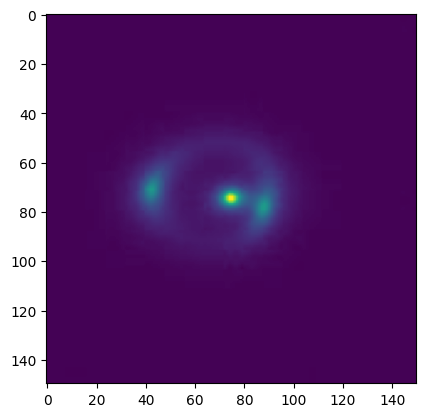

In [63]:
plt.imshow(X_list[5000][0])
plt.show()

In [62]:
y_list[5000]

1

In [69]:
X_list = np.tile(X_list, (1, 3, 1, 1))

In [70]:
X_list = np.array(X_list)
y_list = np.array(y_list)

In [71]:
shuffle_list = np.arange(0, 10000, 1)
random.shuffle( shuffle_list )

In [72]:
X_list = X_list[shuffle_list]
y_list = y_list[shuffle_list]

In [73]:
class MyDataset(Dataset):
    def __init__(self, train = True, transform = None, target_transform = None):
        global X_list, y_list
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        if self.train:
            return 9000
        else:
            return 1000
    
    def __getitem__(self,idx):
        if self.train:
            image, label = torch.from_numpy( X_list[idx] ), y_list[idx]
        else:
            image, label = torch.from_numpy( X_list[idx+9000] ), y_list[idx+9000]
        
        if self.transform:
            image = self.transform( image )
        if self.target_transform:
            label = self.target_transform( label )

        return image, label 

In [11]:
my_transform_pretrained = transforms.Resize((224,224))
my_transform_single_channel = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
    ])

### Data Augmentation

In [12]:
my_transform_augmentation = transforms.Compose( [transforms.RandomRotation(degrees=90), transforms.Resize((224, 224))] )

In [64]:
train_set = MyDataset(train=True, transform=my_transform_pretrained)
train_loader =  DataLoader(train_set, batch_size=200, shuffle=True)

In [65]:
train_set_not_aug = MyDataset(train=True, transform=my_transform_pretrained)
train_loader_not_aug =  DataLoader(train_set_not_aug, batch_size=200, shuffle=False)

In [66]:
test_set = MyDataset(train=False, transform=my_transform_pretrained)
test_loader =  DataLoader(test_set, batch_size=200, shuffle=False)

## III. Train and Test Loop

In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    
    size = len(dataloader.dataset)
    running_loss = 0.
    #total_sample = 0
    for batch_i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Compute prediction and loss
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        num_batch_print = 9
        if batch_i % num_batch_print == num_batch_print - 1:
            current = (batch_i + 1) * len(inputs)
            print(f'batch: [{batch_i + 1:5d}], loss: {running_loss / num_batch_print:.3f}')
            print(f'temporary loss: {loss.item():>7f} | [{current:>5d}/{size:>5d}]')
            running_loss = 0

In [18]:
def test_loop_Entropy(dataloader, model, loss_fn):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    total = 0
    
    with torch.no_grad():
        for data in dataloader:
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            
            # classify which class the output in
            _, predicted = torch.max(outputs.data, 1)
            #_, labels_value = torch.max(labels.data, 1)
            
            # obtain the statistics of test loss and correctness
            test_loss += loss_fn(outputs, labels).item()
            correct += (predicted == labels).sum().item() 
            #correct += (predicted == labels_value).sum().item() 
            total += labels.size(0)

    print(f"Test Error: \n Accuracy: {(100 * correct / total):>0.1f}%")
    print(f"Avg loss: {test_loss / num_batches:>8f} \n")
    
    return test_loss / num_batches

In [19]:
def test_loop_prob(dataloader, model, class_i):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    total_prob = list()
    total_label = list()
    i = 0
    with torch.no_grad():
        for (i, data) in enumerate(dataloader):
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, class_i]
            
            total_prob += torch.Tensor.cpu(probabilities).numpy().tolist()
            
            total_label += torch.Tensor.cpu(labels==class_i).numpy().tolist()
            
            if i % 25 == 0:
                print(f"Process: {i/num_batches*100}\%")
    return np.array(total_prob), np.array(total_label)

## III. ResNet-18 (baseline)

1. Accuracy: 99.5%
2. ROC-AUC score: 0.9999

In [75]:
# Pre-trained ResNet18
model_ResNet18 = torchvision.models.resnet18(pretrained=True).to(device)
in_features = model_ResNet18.fc.in_features
model_ResNet18.fc = nn.Linear(in_features, 2, device=device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
lr_list = [1e-4] * 10 + [1e-5] * 5 + [1e-6] * 5
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_ResNet18, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [    9], loss: 0.683
temporary loss: 0.647695 | [ 1800/ 9000]
batch: [   18], loss: 0.571
temporary loss: 0.523562 | [ 3600/ 9000]
batch: [   27], loss: 0.439
temporary loss: 0.342949 | [ 5400/ 9000]
batch: [   36], loss: 0.361
temporary loss: 0.325334 | [ 7200/ 9000]
batch: [   45], loss: 0.281
temporary loss: 0.248340 | [ 9000/ 9000]
Train Set
Test Error: 
 Accuracy: 55.7%
Avg loss: 0.712740 

Test Set
Test Error: 
 Accuracy: 56.1%
Avg loss: 0.709432 

-------------Epoch 2-------------
batch: [    9], loss: 0.289
temporary loss: 0.294113 | [ 1800/ 9000]
batch: [   18], loss: 0.212
temporary loss: 0.159526 | [ 3600/ 9000]
batch: [   27], loss: 0.174
temporary loss: 0.177555 | [ 5400/ 9000]
batch: [   36], loss: 0.149
temporary loss: 0.152508 | [ 7200/ 9000]
batch: [   45], loss: 0.095
temporary loss: 0.103392 | [ 9000/ 9000]
Train Set
Test Error: 
 Accuracy: 86.3%
Avg loss: 0.304784 

Test Set
Test Error: 
 Accuracy: 83.9%
Avg loss: 0.375916 



In [83]:
path ="/content/gdrive/MyDrive/DeepLense_model/DeepLense_Additional_task_ResNet18_weights.pth"
torch.save(model_ResNet18.state_dict(), path)

In [77]:
total_prob_ResNet18, total_label_ResNet18 = test_loop_prob(test_loader, model_ResNet18, class_i=0)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ResNet18, total_prob_ResNet18)
ResNet18_AUC_1 = metrics.roc_auc_score(total_label_ResNet18, total_prob_ResNet18)

Process: 0.0\%


In [78]:
print("The ROC-AUC score of Pre-trained ResNet-18 is:", ResNet18_AUC_1)

The ROC-AUC score of Pre-trained ResNet-18 is: 0.9999079554504381


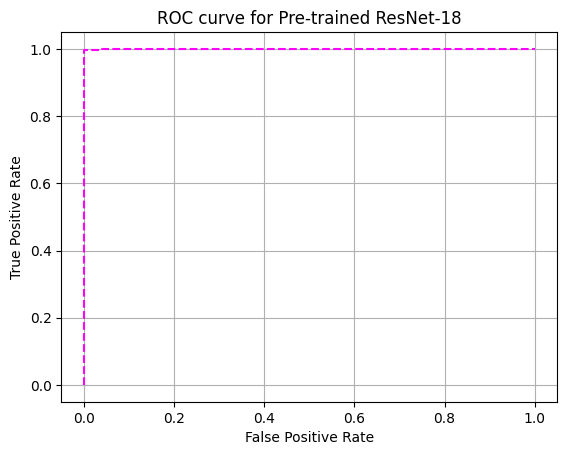

In [79]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained ResNet-18")
plt.show()

## IV. Vision Transformer (ViT)

1. Accuracy: 97.9%
2. ROC-AUC score: 0.9987

In [81]:
model_ViT = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
#model_ViT = torchvision.models.vit_b_16().to(device)
in_features = model_ViT.heads.head.in_features
model_ViT.heads.head = nn.Linear(in_features, 2, device=device)

In [82]:
lr_list = [1e-5] * 5
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    print("train set")
    test_loop_Entropy(train_loader_not_aug, model_ViT, criterion)
    print("test set")
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [    9], loss: 0.702
temporary loss: 0.695854 | [ 1800/ 9000]
batch: [   18], loss: 0.685
temporary loss: 0.689964 | [ 3600/ 9000]
batch: [   27], loss: 0.673
temporary loss: 0.658854 | [ 5400/ 9000]
batch: [   36], loss: 0.625
temporary loss: 0.606742 | [ 7200/ 9000]
batch: [   45], loss: 0.542
temporary loss: 0.456408 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 77.8%
Avg loss: 0.464610 

test set
Test Error: 
 Accuracy: 76.7%
Avg loss: 0.477162 

-------------Epoch 2-------------
batch: [    9], loss: 0.515
temporary loss: 0.486165 | [ 1800/ 9000]
batch: [   18], loss: 0.433
temporary loss: 0.436168 | [ 3600/ 9000]
batch: [   27], loss: 0.360
temporary loss: 0.293547 | [ 5400/ 9000]
batch: [   36], loss: 0.299
temporary loss: 0.306966 | [ 7200/ 9000]
batch: [   45], loss: 0.277
temporary loss: 0.195957 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 82.4%
Avg loss: 0.320086 

test set
Test Error: 
 Accuracy: 81.3%
Avg loss: 0.343528 



In [84]:
lr_list = [1e-6] * 10
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    print("train set")
    test_loop_Entropy(train_loader_not_aug, model_ViT, criterion)
    print("test set")
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [    9], loss: 0.125
temporary loss: 0.104630 | [ 1800/ 9000]
batch: [   18], loss: 0.125
temporary loss: 0.121095 | [ 3600/ 9000]
batch: [   27], loss: 0.122
temporary loss: 0.126424 | [ 5400/ 9000]
batch: [   36], loss: 0.105
temporary loss: 0.097963 | [ 7200/ 9000]
batch: [   45], loss: 0.124
temporary loss: 0.104697 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 95.8%
Avg loss: 0.104379 

test set
Test Error: 
 Accuracy: 95.5%
Avg loss: 0.114945 

-------------Epoch 2-------------
batch: [    9], loss: 0.099
temporary loss: 0.125410 | [ 1800/ 9000]
batch: [   18], loss: 0.099
temporary loss: 0.122631 | [ 3600/ 9000]
batch: [   27], loss: 0.105
temporary loss: 0.100135 | [ 5400/ 9000]
batch: [   36], loss: 0.086
temporary loss: 0.095718 | [ 7200/ 9000]
batch: [   45], loss: 0.101
temporary loss: 0.081519 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 96.6%
Avg loss: 0.084842 

test set
Test Error: 
 Accuracy: 96.2%
Avg loss: 0.094646 



In [85]:
path ="/content/gdrive/MyDrive/DeepLense_model/DeepLense_Additional_task_ViT_weights.pth"
torch.save(model_ViT.state_dict(), path)

### ROC-AUC (ViT)

In [86]:
total_prob_ViT, total_label_ViT = test_loop_prob(test_loader, model_ViT, class_i=0)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ViT, total_prob_ViT)
ViT_AUC_1 = metrics.roc_auc_score(total_label_ViT, total_prob_ViT)

Process: 0.0\%


In [87]:
print("The ROC-AUC score of Pre-trained ViT is:", ViT_AUC_1)

The ROC-AUC score of Pre-trained ViT is: 0.9987393898646946


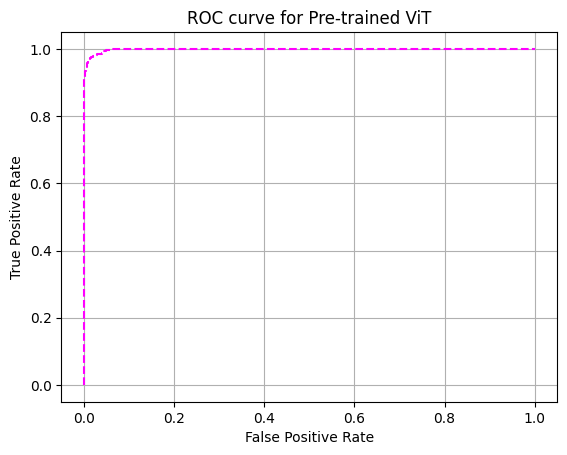

In [88]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained ViT")
plt.show()

## V. Swin Transformer

1. Accuracy: 94.0% - 94.6%

2. ROC-AUC score: 0.9894

In [91]:
model_swin_t = torchvision.models.swin_t(weights=torchvision.models.Swin_T_Weights.IMAGENET1K_V1).to(device)
in_features = model_swin_t.head.in_features
model_swin_t.head = nn.Linear(in_features, 2, device=device)

In [92]:
lr_list = [1e-5] * 10
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_swin_t.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_swin_t, criterion, optimizer)
    print("train set")
    test_loop_Entropy(train_loader_not_aug, model_swin_t, criterion)
    print("test set")
    test_loop_Entropy(test_loader, model_swin_t, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [    9], loss: 0.702
temporary loss: 0.687390 | [ 1800/ 9000]
batch: [   18], loss: 0.697
temporary loss: 0.698830 | [ 3600/ 9000]
batch: [   27], loss: 0.692
temporary loss: 0.683210 | [ 5400/ 9000]
batch: [   36], loss: 0.687
temporary loss: 0.689070 | [ 7200/ 9000]
batch: [   45], loss: 0.684
temporary loss: 0.682049 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 65.4%
Avg loss: 0.667355 

test set
Test Error: 
 Accuracy: 66.1%
Avg loss: 0.666725 

-------------Epoch 2-------------
batch: [    9], loss: 0.676
temporary loss: 0.666921 | [ 1800/ 9000]
batch: [   18], loss: 0.670
temporary loss: 0.648757 | [ 3600/ 9000]
batch: [   27], loss: 0.655
temporary loss: 0.657836 | [ 5400/ 9000]
batch: [   36], loss: 0.652
temporary loss: 0.653058 | [ 7200/ 9000]
batch: [   45], loss: 0.631
temporary loss: 0.621831 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 57.9%
Avg loss: 0.613527 

test set
Test Error: 
 Accuracy: 55.9%
Avg loss: 0.622259 



In [93]:
lr_list = [1e-6] * 5 + [1e-7] * 5
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_swin_t.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_swin_t, criterion, optimizer)
    print("train set")
    test_loop_Entropy(train_loader_not_aug, model_swin_t, criterion)
    print("test set")
    test_loop_Entropy(test_loader, model_swin_t, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [    9], loss: 0.265
temporary loss: 0.286800 | [ 1800/ 9000]
batch: [   18], loss: 0.245
temporary loss: 0.217490 | [ 3600/ 9000]
batch: [   27], loss: 0.242
temporary loss: 0.191520 | [ 5400/ 9000]
batch: [   36], loss: 0.256
temporary loss: 0.239969 | [ 7200/ 9000]
batch: [   45], loss: 0.244
temporary loss: 0.242480 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 93.8%
Avg loss: 0.136503 

test set
Test Error: 
 Accuracy: 92.7%
Avg loss: 0.165679 

-------------Epoch 2-------------
batch: [    9], loss: 0.250
temporary loss: 0.238037 | [ 1800/ 9000]
batch: [   18], loss: 0.264
temporary loss: 0.246262 | [ 3600/ 9000]
batch: [   27], loss: 0.237
temporary loss: 0.298812 | [ 5400/ 9000]
batch: [   36], loss: 0.228
temporary loss: 0.236915 | [ 7200/ 9000]
batch: [   45], loss: 0.230
temporary loss: 0.218312 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 94.8%
Avg loss: 0.121703 

test set
Test Error: 
 Accuracy: 93.4%
Avg loss: 0.149620 



In [97]:
path ="/content/gdrive/MyDrive/DeepLense_model/DeepLense_Additional_task_Swin_tiny_weights.pth"
torch.save(model_swin_t.state_dict(), path)

### ROC-AUC (Swin Transformer)

In [94]:
total_prob_swin_t, total_label_swin_t = test_loop_prob(test_loader, model_swin_t, class_i=0)
fpr, tpr, thresholds = metrics.roc_curve(total_label_swin_t, total_prob_swin_t)
swin_t_AUC_1 = metrics.roc_auc_score(total_label_swin_t, total_prob_swin_t)

Process: 0.0\%


In [95]:
print("The ROC-AUC score of Pre-trained Swin Transformer (tiny) is:", swin_t_AUC_1)

The ROC-AUC score of Pre-trained Swin Transformer (tiny) is: 0.9894468922958711


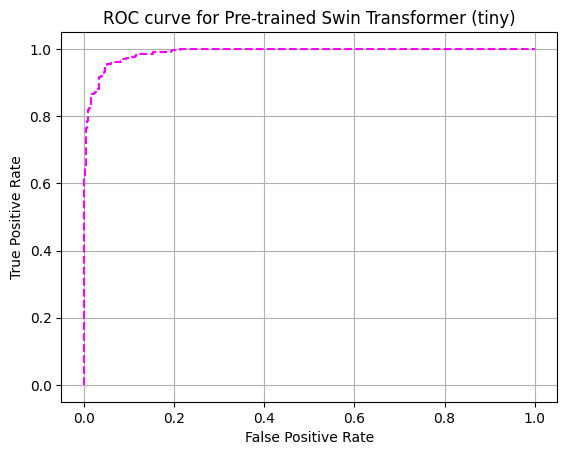

In [96]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained Swin Transformer (tiny)")
plt.show()

## Further Discussion: Data Augmentation

We can also include random rotations (data augmentation) in the training of three models

In [98]:
train_set = MyDataset(train=True, transform=my_transform_augmentation)
train_loader =  DataLoader(train_set, batch_size=200, shuffle=True)

In [99]:
train_set_not_aug = MyDataset(train=True, transform=my_transform_pretrained)
train_loader_not_aug =  DataLoader(train_set_not_aug, batch_size=200, shuffle=False)

In [100]:
test_set = MyDataset(train=False, transform=my_transform_pretrained)
test_loader =  DataLoader(test_set, batch_size=200, shuffle=False)

### ResNet-18 (with data augmentation)

In [101]:
# Pre-trained ResNet18
model_ResNet18 = torchvision.models.resnet18(pretrained=True).to(device)
in_features = model_ResNet18.fc.in_features
model_ResNet18.fc = nn.Linear(in_features, 2, device=device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [102]:
lr_list = [1e-4] * 3
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_ResNet18, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [    9], loss: 0.718
temporary loss: 0.666936 | [ 1800/ 9000]
batch: [   18], loss: 0.655
temporary loss: 0.631962 | [ 3600/ 9000]
batch: [   27], loss: 0.607
temporary loss: 0.609104 | [ 5400/ 9000]
batch: [   36], loss: 0.542
temporary loss: 0.521179 | [ 7200/ 9000]
batch: [   45], loss: 0.506
temporary loss: 0.434379 | [ 9000/ 9000]
Train Set
Test Error: 
 Accuracy: 52.1%
Avg loss: 1.121206 

Test Set
Test Error: 
 Accuracy: 53.0%
Avg loss: 1.097930 

-------------Epoch 2-------------
batch: [    9], loss: 0.456
temporary loss: 0.406600 | [ 1800/ 9000]
batch: [   18], loss: 0.422
temporary loss: 0.362187 | [ 3600/ 9000]
batch: [   27], loss: 0.378
temporary loss: 0.354457 | [ 5400/ 9000]
batch: [   36], loss: 0.325
temporary loss: 0.263295 | [ 7200/ 9000]
batch: [   45], loss: 0.293
temporary loss: 0.270404 | [ 9000/ 9000]
Train Set
Test Error: 
 Accuracy: 79.1%
Avg loss: 0.417312 

Test Set
Test Error: 
 Accuracy: 79.9%
Avg loss: 0.403013 



### ViT (with data augmentation)

In [103]:
model_ViT = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
#model_ViT = torchvision.models.vit_b_16().to(device)
in_features = model_ViT.heads.head.in_features
model_ViT.heads.head = nn.Linear(in_features, 2, device=device)

In [104]:
lr_list = [1e-5] * 3
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    print("train set")
    test_loop_Entropy(train_loader_not_aug, model_ViT, criterion)
    print("test set")
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [    9], loss: 0.689
temporary loss: 0.677114 | [ 1800/ 9000]
batch: [   18], loss: 0.679
temporary loss: 0.674508 | [ 3600/ 9000]
batch: [   27], loss: 0.640
temporary loss: 0.621194 | [ 5400/ 9000]
batch: [   36], loss: 0.570
temporary loss: 0.507000 | [ 7200/ 9000]
batch: [   45], loss: 0.489
temporary loss: 0.505345 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 79.5%
Avg loss: 0.428672 

test set
Test Error: 
 Accuracy: 78.3%
Avg loss: 0.431813 

-------------Epoch 2-------------
batch: [    9], loss: 0.651
temporary loss: 0.588029 | [ 1800/ 9000]
batch: [   18], loss: 0.530
temporary loss: 0.467191 | [ 3600/ 9000]
batch: [   27], loss: 0.440
temporary loss: 0.400609 | [ 5400/ 9000]
batch: [   36], loss: 0.368
temporary loss: 0.367140 | [ 7200/ 9000]
batch: [   45], loss: 0.335
temporary loss: 0.361628 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 83.2%
Avg loss: 0.307351 

test set
Test Error: 
 Accuracy: 82.8%
Avg loss: 0.317860 



### Swin Transformer (with data augmentation)

In [105]:
model_swin_t = torchvision.models.swin_t(weights=torchvision.models.Swin_T_Weights.IMAGENET1K_V1).to(device)
in_features = model_swin_t.head.in_features
model_swin_t.head = nn.Linear(in_features, 2, device=device)

In [106]:
lr_list = [1e-5] * 3
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_swin_t.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_swin_t, criterion, optimizer)
    print("train set")
    test_loop_Entropy(train_loader_not_aug, model_swin_t, criterion)
    print("test set")
    test_loop_Entropy(test_loader, model_swin_t, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [    9], loss: 0.700
temporary loss: 0.709403 | [ 1800/ 9000]
batch: [   18], loss: 0.690
temporary loss: 0.682366 | [ 3600/ 9000]
batch: [   27], loss: 0.689
temporary loss: 0.685686 | [ 5400/ 9000]
batch: [   36], loss: 0.685
temporary loss: 0.691702 | [ 7200/ 9000]
batch: [   45], loss: 0.681
temporary loss: 0.686482 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 63.0%
Avg loss: 0.675172 

test set
Test Error: 
 Accuracy: 63.7%
Avg loss: 0.673616 

-------------Epoch 2-------------
batch: [    9], loss: 0.682
temporary loss: 0.675334 | [ 1800/ 9000]
batch: [   18], loss: 0.676
temporary loss: 0.687184 | [ 3600/ 9000]
batch: [   27], loss: 0.662
temporary loss: 0.657701 | [ 5400/ 9000]
batch: [   36], loss: 0.657
temporary loss: 0.644442 | [ 7200/ 9000]
batch: [   45], loss: 0.654
temporary loss: 0.656038 | [ 9000/ 9000]
train set
Test Error: 
 Accuracy: 72.8%
Avg loss: 0.611063 

test set
Test Error: 
 Accuracy: 72.7%
Avg loss: 0.609147 

